In [1]:
# Imports & Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import warnings

# Scikit-learn & XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (confusion_matrix, precision_recall_curve, 
                             average_precision_score, roc_auc_score, 
                             f1_score, precision_score, recall_score)
import xgboost as xgb

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# --- 1. Suppress Warnings (Clean Output) ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- 2. Configure Paths (Industry Standard) ---
# Set tracking URI to the PARENT directory (outside notebooks folder)
# "file:../mlruns" tells MLflow to create the folder one level up
mlflow.set_tracking_uri("file:../mlruns")

# Create a temporary folder for artifacts (images) if it doesn't exist
ARTIFACT_PATH = "temp_artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)

# --- 3. Experiment Setup ---
EXPERIMENT_NAME = "fraud_detection_v1"
mlflow.set_experiment(EXPERIMENT_NAME)

print(f" MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f" Artifacts Temp Folder: ./{ARTIFACT_PATH}/")
print(" Environment Ready.")

Traceback (most recent call last):
  File "c:\Users\Home\realtime-fraud-detection-mlops\.venv\Lib\site-packages\mlflow\store\tracking\file_store.py", line 376, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Home\realtime-fraud-detection-mlops\.venv\Lib\site-packages\mlflow\store\tracking\file_store.py", line 474, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Home\realtime-fraud-detection-mlops\.venv\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1644, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Home\realtime-fraud-detection-mlops\.venv\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1637, in _read_hel

 MLflow Tracking URI: file:../mlruns
 Artifacts Temp Folder: ./temp_artifacts/
 Environment Ready.


In [2]:
# Load Pre-Processed Data
DATA_PATH = "../data/processed/"

# Load train, validation, and test (already split in Notebook 02)
train_df = pd.read_parquet(DATA_PATH + "train_processed.parquet")
val_df = pd.read_parquet(DATA_PATH + "val_processed.parquet")
test_df = pd.read_parquet(DATA_PATH + "test_processed.parquet")

# Quick validation
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"{'Set':<12} {'Shape':<20} {'Fraud Rate'}")
print("-"*60)
print(f"{'Train':<12} {str(train_df.shape):<20} {train_df['is_fraud'].mean()*100:.3f}%")
print(f"{'Validation':<12} {str(val_df.shape):<20} {val_df['is_fraud'].mean()*100:.3f}%")
print(f"{'Test':<12} {str(test_df.shape):<20} {test_df['is_fraud'].mean()*100:.3f}%")
print("="*60)
print("✓ Data loaded successfully.")
print("\n  Note: Test set will ONLY be used for final champion model evaluation.")

DATASET SUMMARY
Set          Shape                Fraud Rate
------------------------------------------------------------
Train        (170884, 54)         0.211%
Validation   (56961, 54)          0.100%
Test         (56962, 54)          0.132%
✓ Data loaded successfully.

  Note: Test set will ONLY be used for final champion model evaluation.


In [3]:
# Separate Features and Target

# Metadata columns - keep for analysis but exclude from training
METADATA_COLS = ['transaction_id', 'user_id', 'merchant_id', 'timestamp']

# Target column
TARGET = 'is_fraud'

# Feature columns = Everything except metadata and target
feature_cols = [col for col in train_df.columns if col not in METADATA_COLS + [TARGET]]

# ──────────────────────────────────────────────────────────────
# Separate X and y for ALL datasets
# ──────────────────────────────────────────────────────────────

# Training set (for model fitting)
X_train = train_df[feature_cols]
y_train = train_df[TARGET]

# Validation set (for model comparison & hyperparameter tuning)
X_val = val_df[feature_cols]
y_val = val_df[TARGET]

# Test set (ONLY for final champion model evaluation)
X_test = test_df[feature_cols]
y_test = test_df[TARGET]

# Validation
print("="*60)
print("FEATURE/TARGET SPLIT SUMMARY")
print("="*60)
print(f"Features: {len(feature_cols)} columns")
print("-"*60)
print(f"{'Set':<12} {'X Shape':<20} {'y Shape'}")
print("-"*60)
print(f"{'Train':<12} {str(X_train.shape):<20} {str(y_train.shape)}")
print(f"{'Validation':<12} {str(X_val.shape):<20} {str(y_val.shape)}")
print(f"{'Test':<12} {str(X_test.shape):<20} {str(y_test.shape)}")
print("="*60)
print(" Features and Target separated.")

FEATURE/TARGET SPLIT SUMMARY
Features: 49 columns
------------------------------------------------------------
Set          X Shape              y Shape
------------------------------------------------------------
Train        (170884, 49)         (170884,)
Validation   (56961, 49)          (56961,)
Test         (56962, 49)          (56962,)
 Features and Target separated.


In [4]:
# Evaluation Helper Functions (Clean Version)
# No changes needed - functions are generic

def evaluate_model(model, X, y, model_name="Model"):
    """Calculate and return all evaluation metrics."""
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    metrics = {
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1_score': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_prob),
        'pr_auc': average_precision_score(y, y_prob)
    }
    return metrics, y_pred, y_prob


def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Plot confusion matrix and return the Figure object.
    Does NOT save to disk automatically.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    plt.tight_layout()
    
    return fig

print(" Evaluation functions ready.")

 Evaluation functions ready.


In [5]:

# Baseline Experiment - Logistic Regression (Evaluate on VALIDATION set)

# Define Preprocessor
categorical_cols = ['card_tier', 'transaction_channel']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', RobustScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

# Setup Temp Directory
ARTIFACT_PATH = "temp_artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)

run_name = "Baseline_LogReg_Balanced"

try:
    with mlflow.start_run(run_name=run_name):
        print(f"Starting Run: {run_name}")
        print("  Training on: train_df")
        print("  Evaluating on: val_df (NOT test_df)")
        
        # --- Define & Train Pipeline ---
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
        ])
        pipeline.fit(X_train, y_train)
        
        # --- Evaluate on VALIDATION set ---
        metrics, y_pred, y_prob = evaluate_model(pipeline, X_val, y_val)
        
        # --- Log Metrics ---
        print("\nValidation Metrics:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")
            mlflow.log_metric(k, v)
            
        # --- Log Params ---
        mlflow.log_param("model_type", "Logistic Regression")
        mlflow.log_param("eval_set", "validation")  # Track which set was used
        
        # --- Handle Artifacts ---
        fig = plot_confusion_matrix(y_val, y_pred, model_name=run_name)
        temp_file = f"{ARTIFACT_PATH}/confusion_matrix_{run_name}.png"
        fig.savefig(temp_file)
        plt.close(fig)
        mlflow.log_artifact(temp_file)
        
        # --- Log Model ---
        input_example = X_train.iloc[:5]
        signature = infer_signature(input_example, pipeline.predict(input_example))
        mlflow.sklearn.log_model(
            sk_model=pipeline, 
            artifact_path="model",
            signature=signature, 
            input_example=input_example
        )
        print(f"Run Complete. Evaluated on VALIDATION set.")

finally:
    if os.path.exists(ARTIFACT_PATH):
        shutil.rmtree(ARTIFACT_PATH)
        print(f"Cleaned up: {ARTIFACT_PATH}/")

Starting Run: Baseline_LogReg_Balanced
  Training on: train_df
  Evaluating on: val_df (NOT test_df)

Validation Metrics:
  precision: 0.0370
  recall: 0.9123
  f1_score: 0.0711
  roc_auc: 0.9899
  pr_auc: 0.7830


2025/12/08 18:15:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/08 18:15:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Run Complete. Evaluated on VALIDATION set.
Cleaned up: temp_artifacts/


In [6]:
# Challenger Experiment - XGBoost + SMOTE (Evaluate on VALIDATION set)

ARTIFACT_PATH = "temp_artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)

run_name = "Challenger_XGB_SMOTE"

try:
    with mlflow.start_run(run_name=run_name):
        print(f"Starting Run: {run_name}")
        print("  Training on: train_df")
        print("  Evaluating on: val_df (NOT test_df)")
        
        # --- Define Pipeline ---
        pipeline_xgb = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
            ('classifier', xgb.XGBClassifier(
                objective='binary:logistic',
                eval_metric='aucpr',
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1
            ))
        ])
        
        # --- Log Parameters ---
        mlflow.log_param("model_type", "XGBoost")
        mlflow.log_param("smote_strategy", "0.1")
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("eval_set", "validation")
        
        # --- Train ---
        pipeline_xgb.fit(X_train, y_train)
        
        # --- Evaluate on VALIDATION set ---
        metrics, y_pred, y_prob = evaluate_model(pipeline_xgb, X_val, y_val)
        
        # --- Log Metrics ---
        print("\nValidation Metrics:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")
            mlflow.log_metric(k, v)
            
        # --- Artifacts ---
        fig = plot_confusion_matrix(y_val, y_pred, model_name=run_name)
        temp_file = f"{ARTIFACT_PATH}/confusion_matrix_{run_name}.png"
        fig.savefig(temp_file)
        plt.close(fig)
        mlflow.log_artifact(temp_file)
        
        # --- Log Model ---
        input_example = X_train.iloc[:5]
        signature = infer_signature(input_example, pipeline_xgb.predict(input_example))
        mlflow.sklearn.log_model(
            sk_model=pipeline_xgb, 
            artifact_path="model",
            signature=signature, 
            input_example=input_example
        )
        print(f"Run Complete. Evaluated on VALIDATION set.")

finally:
    if os.path.exists(ARTIFACT_PATH):
        shutil.rmtree(ARTIFACT_PATH)
        print(f"Cleaned up: {ARTIFACT_PATH}/")

Starting Run: Challenger_XGB_SMOTE
  Training on: train_df
  Evaluating on: val_df (NOT test_df)

Validation Metrics:
  precision: 0.8723
  recall: 0.7193
  f1_score: 0.7885
  roc_auc: 0.9786
  pr_auc: 0.7598


2025/12/08 18:15:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/08 18:16:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Run Complete. Evaluated on VALIDATION set.
Cleaned up: temp_artifacts/


In [7]:
# Optimization - XGBoost with Class Weights (Evaluate on VALIDATION set)

ARTIFACT_PATH = "temp_artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)

run_name = "XGB_ClassWeights_Optimized"

# Calculate scale_pos_weight from TRAINING data only
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_weight = neg_count / pos_count

print(f"Calculated scale_pos_weight: {scale_weight:.2f}")

try:
    with mlflow.start_run(run_name=run_name):
        print(f"Starting Run: {run_name}")
        print("  Training on: train_df")
        print("  Evaluating on: val_df (NOT test_df)")
        
        # --- Define Pipeline (NO SMOTE) ---
        pipeline_weighted = ImbPipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb.XGBClassifier(
                objective='binary:logistic',
                eval_metric='aucpr',
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                scale_pos_weight=scale_weight,
                random_state=42,
                n_jobs=-1
            ))
        ])
        
        # --- Log Params ---
        mlflow.log_param("model_type", "XGBoost")
        mlflow.log_param("technique", "Class Weights")
        mlflow.log_param("scale_pos_weight", round(scale_weight, 2))
        mlflow.log_param("eval_set", "validation")
        
        # --- Train ---
        pipeline_weighted.fit(X_train, y_train)
        
        # --- Evaluate on VALIDATION set ---
        metrics, y_pred, y_prob = evaluate_model(pipeline_weighted, X_val, y_val)
        
        print("\nValidation Metrics:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")
            mlflow.log_metric(k, v)
            
        # --- Artifacts ---
        fig = plot_confusion_matrix(y_val, y_pred, model_name=run_name)
        temp_file = f"{ARTIFACT_PATH}/confusion_matrix_{run_name}.png"
        fig.savefig(temp_file)
        plt.close(fig)
        mlflow.log_artifact(temp_file)
        
        # --- Log Model ---
        input_example = X_train.iloc[:5]
        signature = infer_signature(input_example, pipeline_weighted.predict(input_example))
        mlflow.sklearn.log_model(
            sk_model=pipeline_weighted, 
            artifact_path="model",
            signature=signature, 
            input_example=input_example
        )
        print(f"Run Complete. Evaluated on VALIDATION set.")

finally:
    if os.path.exists(ARTIFACT_PATH):
        shutil.rmtree(ARTIFACT_PATH)
        print(f"Cleaned up: {ARTIFACT_PATH}/")

Calculated scale_pos_weight: 473.68
Starting Run: XGB_ClassWeights_Optimized
  Training on: train_df
  Evaluating on: val_df (NOT test_df)

Validation Metrics:
  precision: 0.8269
  recall: 0.7544
  f1_score: 0.7890
  roc_auc: 0.9771
  pr_auc: 0.7492


2025/12/08 18:16:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/08 18:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Run Complete. Evaluated on VALIDATION set.
Cleaned up: temp_artifacts/


Traceback (most recent call last):
  File "c:\Users\Home\realtime-fraud-detection-mlops\.venv\Lib\site-packages\mlflow\store\tracking\file_store.py", line 376, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Home\realtime-fraud-detection-mlops\.venv\Lib\site-packages\mlflow\store\tracking\file_store.py", line 474, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Home\realtime-fraud-detection-mlops\.venv\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1644, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Home\realtime-fraud-detection-mlops\.venv\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1637, in _read_hel

CHAMPION MODEL SELECTION

CHAMPION MODEL: Challenger_XGB_SMOTE
   Run ID: 1a865857537f4a30890f92685a739ebe
   Validation PR-AUC: 0.8203



FINAL TEST SET EVALUATION (First Time Touching Test Data!)

TEST SET METRICS (Unbiased Performance Estimate):
----------------------------------------
  precision: 0.8906
  recall: 0.7600
  f1_score: 0.8201
  roc_auc: 0.9862
  pr_auc: 0.8260

Test metrics logged to MLflow with 'test_' prefix.

VALIDATION vs TEST COMPARISON
Metric            Validation         Test   Difference
------------------------------------------------------------
precision             0.8906       0.8906      +0.0000 OK
recall                0.7600       0.7600      +0.0000 OK
f1_score              0.8201       0.8201      +0.0000 OK
roc_auc               0.9881       0.9862      -0.0020 OK
pr_auc                0.8203       0.8260      +0.0057 OK

Insight: Small differences indicate good generalization.
   Large drops may indicate overfitting to validation set.


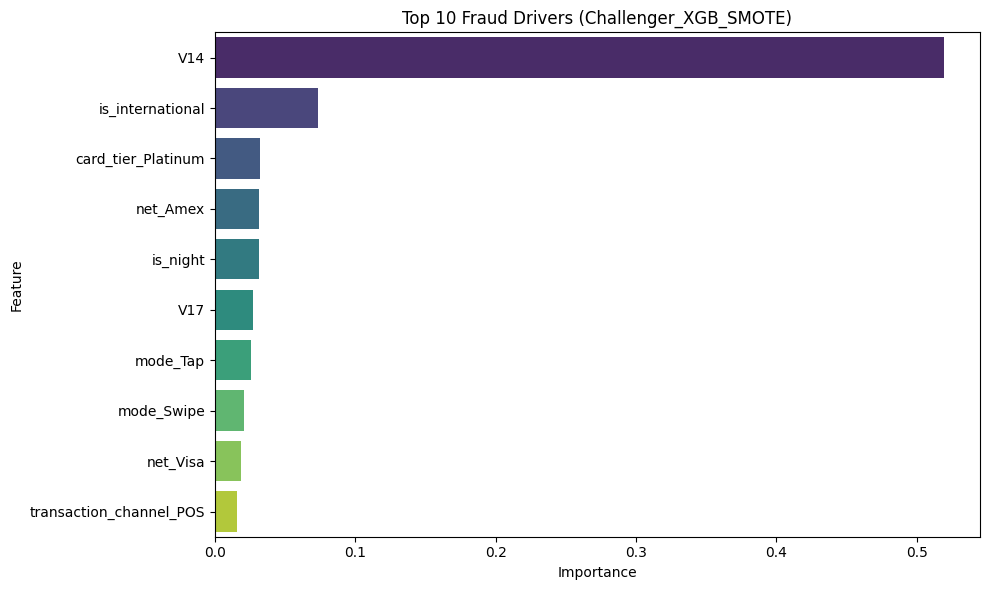


Model ready for deployment!
   Deploy using Run ID: 1a865857537f4a30890f92685a739ebe


In [8]:
print("="*60)
print("CHAMPION MODEL SELECTION")
print("="*60)

# 1. Compare all runs based on VALIDATION metrics
runs = mlflow.search_runs(
    experiment_ids=[mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id]
)

# Sort by PR-AUC (Best metric for imbalance)
best_run = runs.sort_values("metrics.pr_auc", ascending=False).iloc[0]

best_run_id = best_run["run_id"]
best_model_name = best_run["tags.mlflow.runName"]
best_val_score = best_run["metrics.pr_auc"]

print(f"\nCHAMPION MODEL: {best_model_name}")
print(f"   Run ID: {best_run_id}")
print(f"   Validation PR-AUC: {best_val_score:.4f}")

# 2. Load the Champion Model
champion_model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/model")

# 3. FINAL EVALUATION ON TEST SET (First and Only Time!)
print("\n" + "="*60)
print("FINAL TEST SET EVALUATION (First Time Touching Test Data!)")
print("="*60)

test_metrics, y_test_pred, y_test_prob = evaluate_model(
    champion_model, X_test, y_test, model_name=best_model_name
)

print("\nTEST SET METRICS (Unbiased Performance Estimate):")
print("-"*40)
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

# 4. Log Test Metrics to the Champion Run
with mlflow.start_run(run_id=best_run_id):
    for k, v in test_metrics.items():
        mlflow.log_metric(f"test_{k}", v)  # Prefix with 'test_' to distinguish
    mlflow.log_param("final_eval_set", "test")
    
print("\nTest metrics logged to MLflow with 'test_' prefix.")

# 5. Compare Validation vs Test Performance
print("\n" + "="*60)
print("VALIDATION vs TEST COMPARISON")
print("="*60)
print(f"{'Metric':<15} {'Validation':>12} {'Test':>12} {'Difference':>12}")
print("-"*60)

val_metrics_keys = ['precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc']
for k in val_metrics_keys:
    val_score = best_run[f"metrics.{k}"]
    test_score = test_metrics[k]
    diff = test_score - val_score
    status = "OK" if abs(diff) < 0.05 else "Warning"
    print(f"{k:<15} {val_score:>12.4f} {test_score:>12.4f} {diff:>+12.4f} {status}")

print("="*60)
print("\nInsight: Small differences indicate good generalization.")
print("   Large drops may indicate overfitting to validation set.")

# 6. Feature Importance (Same as before)
if "XGB" in best_model_name:
    xgb_model = champion_model.named_steps['classifier']
    preprocessor = champion_model.named_steps['preprocessor']
    
    cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    all_feature_names = list(cat_names) + list(numerical_cols)
    
    importances = xgb_model.feature_importances_
    
    feat_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
    plt.title(f"Top 10 Fraud Drivers ({best_model_name})")
    plt.tight_layout()
    plt.show()

print("\nModel ready for deployment!")
print(f"   Deploy using Run ID: {best_run_id}")

In [9]:
import numpy as np
import shap

print(f"NumPy version: {np.__version__}")
print(f"SHAP version: {shap.__version__}")
print("SHAP imported successfully!")

NumPy version: 2.3.5
SHAP version: 0.50.0
SHAP imported successfully!


Explaining Champion Model: Challenger_XGB_SMOTE
  Using: Test set sample (100 transactions)
  Using TreeExplainer (Fast)
SHAP plot saved: temp_artifacts/shap_summary_1a865857537f4a30890f92685a739ebe.png
SHAP Summary logged to MLflow.


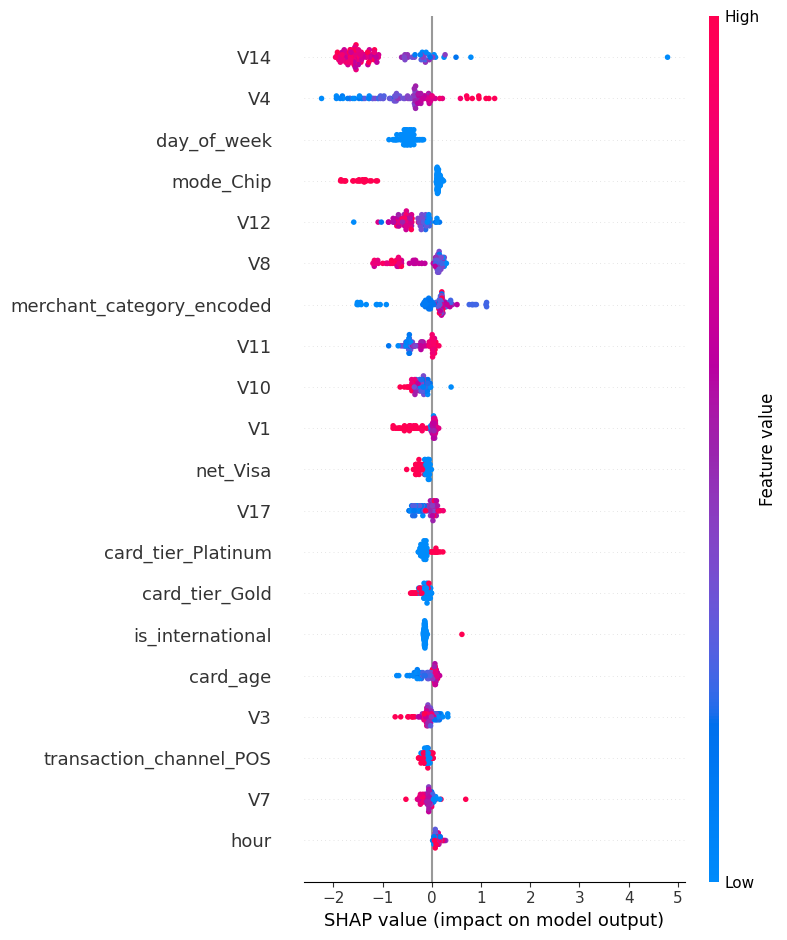

Cleaned up: temp_artifacts/


In [11]:
import shap

ARTIFACT_PATH = "temp_artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)

preprocessor = champion_model.named_steps['preprocessor']
classifier = champion_model.named_steps['classifier']

# Use TEST set sample for SHAP (Champion model is now final)
X_sample = X_test.sample(100, random_state=42)
X_sample_transformed = preprocessor.transform(X_sample)

print(f"Explaining Champion Model: {best_model_name}")
print(f"  Using: Test set sample (100 transactions)")

# Get feature names
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_names = list(cat_names) + list(numerical_cols)

if any(model in best_model_name.upper() for model in ['RANDOMFOREST', 'XGB']):
    print("  Using TreeExplainer (Fast)")
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_sample_transformed)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # Summary Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample_transformed, 
                      feature_names=all_names, 
                      show=False)
    
    temp_file = f"{ARTIFACT_PATH}/shap_summary_{best_run_id}.png"
    plt.savefig(temp_file, bbox_inches='tight', dpi=150)
    plt.close()
    
    print(f"SHAP plot saved: {temp_file}")
    
    # Log to MLflow
    with mlflow.start_run(run_id=best_run_id):
        mlflow.log_artifact(temp_file)
    
    print("SHAP Summary logged to MLflow.")
    
    # Show the plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample_transformed, 
                      feature_names=all_names)

else:
    print("  Using LinearExplainer for non-tree models")

# Cleanup
if os.path.exists(ARTIFACT_PATH):
    shutil.rmtree(ARTIFACT_PATH)
    print(f"Cleaned up: {ARTIFACT_PATH}/")